# Обработка неполных данных в деревьях решений

### Цель работы
Исследовать методы обработки пропущенных значений в табличных данных и реализовать модифицированное дерево решений, не игнорирующее наблюдени с пропусками. Провести сравнительный анализ предложенного метода с классическими деревьями решений и градиентным бустингом (XGBoost).

## Идея алгоритма
Во время разбиения по признаку, который отсутствует у наблюдения, добавлять наблюдение в обе формируемые ветви. Из-за этого вместо точного ответа будет получаться ответ вероятностный (как именно выбрать итоговый класс остаётся на личное усмотрение).

## Задачи
* Изучить существующие методы обработки неполных данных и типы пропусков.
* Реализовать класс `AdaptiveDecisionTreeClassifier` для дерева решений с обработкой пропусков (в качестве критерия разбиения Gini или энтропия, входные данные числовые).
* Провести сравнение предложенного метода с обычным деревом решений (`sklearn.tree.DecisionTreeClassifier`) и градиентным бустингом (`XGBoost`).
* Использовать учебные наборы данных (например, [Iris](https://www.kaggle.com/datasets/himanshunakrani/iris-dataset), [Titanic](https://www.kaggle.com/datasets/yasserh/titanic-dataset), [Adult Income](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset), любые другие табличные наборы для классификации).
* Оценить влияние пропусков на качество моделей, используя метрики (Accuracy, F1-score).


## Ожидаемые результаты
* Теоретический обзор (краткое описание методов).
* Код реализации дерева решений.
* Графики / таблицы, демонстрирующие результаты сравнения.
* Выводы о преимуществах и недостатках предложенного метода.

## Требования к реализации
* Код должен быть написан на Python версии 3.9 и выше.
* Рекомендуемые библиотеки: `numpy`, `pandas`, `scikit-learn`, `xgboost`, `matplotlib`).
* Стиль кода соответствует PEP8.
* Реализация дерева решений должна быть в виде отдельного класса с методами `fit`, `predict`.
* Датасеты и код для экспериментов должны быть воспроизводимыми.

## Заготовка класса:

```python
import numpy as np


class AdaptiveDecisionTreeClassifier:
   def __init__(self, criterion: str = "gini", min_samples_split: int = 2, min_samples_leaf: int = 1):
      pass

   def fit(self, x: np.ndarray, y: np.array) -> "AdaptiveDecisionTreeClassifier":
      pass

   def predict(self, x: np.ndarray) -> np.array:
      pass

   def get_depth(self) -> int:
      pass
```

## Краткая теоретическая справка

##### **Дерево решений** — алгоритм машинного обучения, используемый для задач классификации и регрессии. Реализует иерархическую структуру узлов, где каждый узел проверяет условие на атрибуте, чтобы разделить данные на ветви.  
---
### Методы поиска лучшего разделения в узле
#### 1. Критерий Джини
**Критерий Джини** измеряет неоднородность в узле.  
Формула для узла:  
$$
G = 1 - \sum_{i=1}^{n} p_i^2
$$  
где $p_i$ — доля объектов класса i в узле.

- **Чем ниже значение Джини**, тем чище узел.   

Алгоритм выбирает разбиение, которое **минимизирует суммарный критерий Джини** для дочерних узлов.

**Взвешенная неоднородность** после разбиения на левую $L$ и правую $R$ ветви:
$$
G_{\text{weighted}} = \frac{W_L \cdot G_L + W_R \cdot G_R}{W_L + W_R}
$$
где $W_L, W_R$ — суммарные веса объектов в левой и правой ветвях.

#### 2. Критерий энтропии
**Энтропия** оценивает хаотичность в узле.  
Формула:  
$$
H = -\sum_{i=1}^{n} p_i \cdot \log_2(p_i)
$$  

- **Чем ниже энтропия**, тем однороднее узел (если все объекты принадлежат одному классу H = 0).  

Алгоритм стремится к **минимизации энтропии**.

**Взвешенная энтропия** после разбиения:
$$
H_{\text{weighted}} = \frac{W_L \cdot H_L + W_R \cdot H_R}{W_L + W_R}
$$

---

### Сравнение
- **Джини**:  
  - Быстрее вычисляется
  - Чаще используется в библиотеках

- **Энтропия**:  
  - Сильнее штрафует узлы с неравномерным распределением.  
  - Создает более сбалансированные деревья.  

На практике разница в качестве моделей между ними часто незначительна.

---

### Виды пропущенных данных

Пропуски данных — это отсутствующие значения в наборе данных, которые могут появляться по разным причинам. В статистике и анализе данных пропуски классифицируются на три основных типа в зависимости от механизма их возникновения.


#### 1. Missing Completely at Random (MCAR)
Пропуски данных считаются **Missing Completely at Random (MCAR)**, если вероятность их появления не зависит ни от наблюдаемых данных, ни от самих пропущенных значений. Это означает, что пропуски возникают абсолютно случайно и не связаны с какими-либо закономерностями в данных.

**Пример:**  
В анкете о доходах некоторые участники пропустили вопрос о доходе из-за случайной ошибки при заполнении или сборе данных. Пропуск не связан ни с их доходом, ни с другими характеристиками, такими как возраст или пол.

**Последствия для анализа:**  
- Пропуски MCAR не приводят к систематическому искажению результатов анализа, если их доля невелика.
- Их можно обрабатывать простыми методами, например, удалением строк с пропусками или заменой пропущенных значений на среднее по выборке.

#### 2. Missing at Random (MAR)
 Пропуски данных считаются **Missing at Random (MAR)**, если вероятность их возникновения зависит от других наблюдаемых данных, но не от самих пропущенных значений. Пропуски можно объяснить с помощью доступных переменных в наборе данных.

**Пример:**  
В опросе о доходах мужчины чаще пропускают вопрос о доходе, чем женщины. Здесь вероятность пропуска зависит от пола (наблюдаемой переменной), но не от величины дохода.

**Последствия для анализа:**  
- Пропуски MAR можно обработать, используя информацию из наблюдаемых данных, например, с помощью стратифицированной импьютации (замена пропусков средним значением в зависимости от пола) или моделирования.
- Игнорирование зависимости от наблюдаемых данных может привести к смещению результатов.


#### 3. Missing Not at Random (MNAR)
Пропуски данных считаются **Missing Not at Random (MNAR)**, если вероятность их появления зависит от самих пропущенных значений или от других ненаблюдаемых факторов. Это наиболее сложный тип пропусков, так как их нельзя полностью объяснить с помощью доступных данных.

**Пример:**  
Люди с высоким доходом чаще отказываются сообщать свой доход в анкете. В этом случае пропуски напрямую зависят от величины дохода — пропущенного значения.

**Последствия для анализа:**  
- Пропуски MNAR могут существенно искажать результаты анализа, так как отсутствующие значения систематически отличаются от наблюдаемых.
- Для их обработки требуются сложные методы, такие как моделирование механизма пропусков или проведение чувствительного анализа для оценки влияния пропусков.
---

### Методы обработки пропущенных значений

##### 1. Удаление
Метод предполагает удаление всех строк, содержащих хотя бы одно пропущенное значение. Это простой подход, часто используемый в начальных этапах анализа данных.

**Преимущества:**
- Простота реализации, не требует дополнительных вычислений.
- Не требует предположений о природе пропущенных значений.

**Недостатки:**
- Может привести к значительной потере данных, особенно если пропуски распространены.
- Может привести к смещению модели, если данные не пропущены случайно (MCAR).


##### 2. Импьютация
Замена пропущенных значений на оценочные значения, основанные на доступных данных. Включает:
- **Среднее значение:** Для числовых признаков заменяет пропуски на среднее значение признака.
- **Медиана:** Аналогично, но использует медиану, что может быть лучше при наличии выбросов.
- **Мода:** Для категориальных признаков заменяет пропуски на наиболее частое значение.
- Более продвинутые методы, такие как импьютация на основе k-ближайших соседей или регрессионные модели.

**Преимущества:**
- Сохраняет все данные, избегая потери информации.
- Простота реализации для базовых методов, таких как среднее или мода.

**Недостатки:**
- Может ввести смещение, особенно если данные не пропущены случайно (MAR или MNAR).
- Не всегда точно отражает вариабельность данных, особенно для сложных распределений.


##### 3. Обработка пропусков как отдельной категории
Пропущенные значения рассматриваются как еще одна возможная категория для признака. Для категориальных признаков это означает добавление категории "пропущено". Для числовых признаков можно назначить специальное значение, например, -1, и создать отдельную ветвь в дереве.

**Преимущества:**
- Позволяет напрямую обрабатывать пропуски без предварительной импьютации.
- Дерево решений может научиться различать паттерны, связанные с пропусками, если они имеют значение (пропуски могут указывать на отсутствие информации, что само по себе информативно).

**Недостатки:**
- Предполагает, что пропуски образуют отдельную группу, что может быть неверно, если пропуски случайны.
- Может усложнить дерево, особенно если много признаков имеют пропуски, что увеличивает его размер и сложность.

##### 4. Пропорциональное распределение (метод C4.5/C5)
Когда признак, используемый для разделения, имеет пропущенные значения, экземпляры с пропусками распределяются по дочерним узлам на основе пропорций экземпляров с известными значениями в каждом узле. Например, если 60% известных значений идут в левый дочерний узел, то экземпляр с пропуском имеет 60% вероятность быть отнесенным туда.

**Преимущества:**
- Обрабатывает пропуски без необходимости предварительной импьютации.
- Сохраняет распределение известных значений, что может быть полезно для сохранения структуры данных.

**Недостатки:**
- Может быть неточным, если пропуски не случайны (MAR или MNAR), так как распределение может быть искажено.
- Может быть вычислительно затратным для больших наборов данных, особенно при глубоких деревьях.

##### 5. Суррогатные сплиты (метод CART)
Когда признак, используемый для разделения, имеет пропущенные значения, алгоритм находит другой признак, который имеет схожое поведение разделения (суррогатный сплит), и использует его для определения, в какой дочерний узел направить экземпляр с пропуском.

**Преимущества:**
- Обрабатывает пропуски без импьютации, сохраняя целостность данных.
- Может быть полезно, если суррогатный признак хорошо коррелирует с основным.

**Недостатки:**
- Вычислительно затратно, так как требует поиска подходящего суррогатного признака.
- Может не всегда найти подходящий суррогат, особенно если признаки слабо коррелируют.

##### 6. Вероятностные методы (на основе статьи https://arxiv.org/pdf/2006.16341)
В статье "Handling Missing Data in Decision Trees: A Probabilistic Approach" предлагается использовать вероятностные модели для предсказания пропущенных значений на основе доступных данных. Это может включать:
- **Байесовские сети:** Моделирование зависимостей между признаками для предсказания пропущенных значений.
- **Марковские цепи Монте-Карло (MCMC):** Использование случайных процессов для оценки пропущенных значений.
- **Методы глубокого обучения:** Использование нейронных сетей для предсказания пропущенных значений.

**Преимущества:**
- Высокая точность предсказания пропущенных значений, особенно при наличии сложных зависимостей.
- Способность обрабатывать различные типы пропусков (MCAR, MAR, MNAR).

**Недостатки:**
- Высокая вычислительная сложность, что может быть проблематично для больших наборов данных.
- Требует оценки распределений, что увеличивает вычислительную сложность.
- Реализация сложнее, чем у традиционных методов, таких как удаление или импьютация.

##### Методы и идеи из статьи 6.
В статье авторы предлагают вероятностный подход к обработке пропущенных значений, основанный на моделировании совместного распределения данных. Основные методы включают:
- **Missingness-Incorporated Attribute (MIA):** Пропущенные значения включаются в процесс построения дерева через добавление индикатора пропущенности как части атрибута. Например, для числового признака x  создается новый атрибут (x, m) , где m = 1, если значение пропущено, и m = 0, если значение известно.
- **Probabilistic Splitting:** Вместо детерминированного распределения экземпляров с пропущенными значениями (как в C4.5), используется вероятностное разделение, основанное на оценке апостериорного распределения P(x | y, D), где x — пропущенный атрибут, y  — целевая переменная, а D  — данные.
- **Imputation with Uncertainty:** Выполняется импьютация пропущенных значений с учетом неопределенности, используя выборку из распределения P(x |y, D).

---


## найденные источники

https://loginom.ru/blog/decision-tree-c45-2

https://habr.com/ru/companies/productstar/articles/523044/

https://arxiv.org/pdf/2006.16341

#### Предложенное решение является схожим с методом C4.5

## имопрт библиотек

In [372]:
import pandas as pd
import numpy as np
from abc import ABC, abstractmethod
from copy import copy, deepcopy

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import xgboost as xgb
import sklearn.datasets

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

## Модиффицированное дерево решений

In [ ]:
class Criterion(ABC):
    @staticmethod
    @abstractmethod
    def compute(cls, x: np.ndarray, y: np.ndarray, y_probs: np.array, 
               min_samples_leaf: int) -> tuple:
        pass

class CriterionGini:
    @staticmethod
    def gini(x_atr: np.ndarray, y: np.ndarray, y_probs: np.ndarray, min_samples_leaf: int) -> tuple:
        '''calculating the best threshold by attribute work missing data'''
        non_nan = ~np.isnan(x_atr.astype(float))
        x_clean = x_atr[non_nan]
        y_clean = y[non_nan]
        probs_clean = y_probs[non_nan]
        
        if len(x_clean) < 2 or len(np.unique(y_clean)) < 2:
            return None, 1.0
        
        if np.all(x_clean == x_clean[0]) or len(x_clean) < min_samples_leaf * 2:
            return None, 1.0
        
        #making sorted data to optimize calculations
        order = np.argsort(x_clean)
        x_sorted = x_clean[order]
        y_sorted = y_clean[order]
        probs_sorted = probs_clean[order]
        
        cum_probs = np.cumsum(probs_sorted)
        total_probs = cum_probs[-1]
        
        parent_counts = np.bincount(y, weights=y_probs)
        p_parent = parent_counts / (np.sum(parent_counts) + 1e-10)
        parent_gini = 1 - np.sum(p_parent**2)
        
        #creating a matrix in which each row represents the cumulative probabilities of each unique class
        classes = np.unique(y)
        cum_counts = np.vstack([np.cumsum((y_sorted == cls) * probs_sorted) for cls in classes])
        
        left_probs = cum_probs[:-1]
        right_probs = total_probs - left_probs
        
        #checking the existence of partitions
        valid = (left_probs >= min_samples_leaf) & (right_probs >= min_samples_leaf)
        if not valid.any():
            return None, 1.0
        #p_left is a matrix in which the shares of the class in the left part are written \
            # in each row with all possible splits.
        eps = 1e-10
        p_left = cum_counts[:, :-1] / (left_probs + eps)
        gini_left = 1 - np.sum(p_left**2, axis=0)
        
        ##p_right is a matrix in which the shares of the class in the right part are written \
            # in each row with all possible splits.
        p_right = (cum_counts[:, -1, None] - cum_counts[:, :-1]) / (right_probs + eps)
        gini_right = 1 - np.sum(p_right**2, axis=0)
        
        #weighted gini
        gini_values = (gini_left * left_probs + gini_right * right_probs) / total_probs
        
        #weeding out low-quality thresholds
        gain = parent_gini - gini_values
        gini_values[~valid] = np.inf
        gini_values[gain <= 1e-2] = np.inf
        
        if np.all(np.isinf(gini_values)):
            return None, 1.0
        
        best_idx = np.argmin(gini_values)
        best_threshold = (x_sorted[best_idx] + x_sorted[best_idx + 1]) / 2
        return best_threshold, gini_values[best_idx]
    
    @staticmethod
    def compute(x: np.ndarray, y: np.ndarray, y_probs: np.array, min_samples_leaf: int) -> tuple:
        '''find best threshold for all attributes'''
        best_gini = 1.0
        best_threshold = None
        best_feature_idx = -1
        prob_right = None

        for feature_idx in range(x.shape[1]):
            x_atr = x[:, feature_idx]
            threshold_temp, gini_temp = CriterionGini.gini(x_atr, y, y_probs, min_samples_leaf)
            if threshold_temp is None:
                continue
            if gini_temp < best_gini:
                best_gini = gini_temp
                best_threshold = threshold_temp
                best_feature_idx = feature_idx
                
                non_nan_mask = ~np.isnan(x_atr.astype(float))
                x_atr_non_nan = x_atr[non_nan_mask]
                mask = x_atr_non_nan > best_threshold
                prob_right = np.mean(mask)
                
        return best_feature_idx, best_threshold, best_gini, prob_right


class CriterionEntropy:
    @staticmethod
    def entropy(x_atr: np.ndarray, y: np.ndarray, y_probs: np.ndarray, min_samples_leaf: int) -> tuple:
        '''calculating the best threshold by attribute work missing data'''
        non_nan = ~np.isnan(x_atr.astype(float))
        x_clean = x_atr[non_nan]
        y_clean = y[non_nan]
        probs_clean = y_probs[non_nan]
        
        if len(x_clean) < 2 or len(np.unique(y_clean)) < 2:
            return None, float('inf')
        
        if np.all(x_clean == x_clean[0]) or len(x_clean) < min_samples_leaf * 2:
            return None, float('inf')
        
        #making sorted data to optimize calculations
        order = np.argsort(x_clean)
        x_sorted = x_clean[order]
        y_sorted = y_clean[order]
        probs_sorted = probs_clean[order]
        
        cum_probs = np.cumsum(probs_sorted)
        total_probs = cum_probs[-1]
        eps = 1e-10
        
        parent_counts = np.bincount(y, weights=y_probs)
        p_parent = parent_counts / (np.sum(parent_counts) + eps)
        parent_entropy = -np.sum(p_parent * np.log2(p_parent + eps))
        
        #creating a matrix in which each row represents the cumulative probabilities of each unique class
        classes = np.unique(y)
        cum_class_probs = np.vstack([np.cumsum((y_sorted == cls) * probs_sorted) for cls in classes])
        
        left_probs = cum_probs[:-1]
        right_probs = total_probs - left_probs
        
        #checking the existence of partitions
        valid = (left_probs >= min_samples_leaf) & (right_probs >= min_samples_leaf)
        if not valid.any():
            return None, float('inf')
        
        #p_left is a matrix in which the shares of the class in the left part are written \
            # in each row with all possible splits.
        p_left = cum_class_probs[:, :-1] / (left_probs + eps)
        entropy_left = -np.sum(p_left * np.log2(p_left + eps), axis=0)
        
        ##p_right is a matrix in which the shares of the class in the right part are written \
            # in each row with all possible splits.
        p_right = (cum_class_probs[:, -1, None] - cum_class_probs[:, :-1]) / (right_probs + eps)
        entropy_right = -np.sum(p_right * np.log2(p_right + eps), axis=0)
        
        #weighted entropy
        total_entropy = (entropy_left * left_probs + entropy_right * right_probs) / total_probs
        
        #weeding out low-quality thresholds
        gain = parent_entropy - total_entropy
        total_entropy[~valid] = float('inf')
        total_entropy[gain <= 1e-2] = float('inf')  # Увеличенный порог
        
        if np.all(np.isinf(total_entropy)):
            return None, float('inf')
        
        best_idx = np.argmin(total_entropy)
        best_threshold = (x_sorted[best_idx] + x_sorted[best_idx + 1]) / 2
        return best_threshold, total_entropy[best_idx]
    
    @staticmethod
    def compute(x: np.ndarray, y: np.ndarray, y_probs: np.array, min_samples_leaf: int) -> tuple:
        '''find best threshold for all attributes'''
        best_entropy = float('inf')
        best_threshold = None
        best_feature = -1
        prob_right = None

        for feature_idx in range(x.shape[1]):
            x_atr = x[:, feature_idx]
            threshold_temp, entropy_temp = CriterionEntropy.entropy(x_atr, y, y_probs, min_samples_leaf)
            if threshold_temp is None:
                continue
            if entropy_temp < best_entropy:
                best_entropy = entropy_temp
                best_threshold = threshold_temp
                best_feature = feature_idx

                non_nan_mask = ~np.isnan(x_atr.astype(float))
                x_atr_non_nan = x_atr[non_nan_mask]
                mask = x_atr_non_nan > best_threshold
                prob_right = np.mean(mask)

        return best_feature, best_threshold, best_entropy, prob_right

In [ ]:
class TreeNode:
    def __init__(self, criterion: Criterion, depth: int, num_classes: int, min_samples_split: int = 2, min_samples_leaf: int = 1):
        self.feature_idx = None
        self.threshold = None
        self.left = None
        self.right = None
        self.criterion = criterion
        self.prediction = None
        self.depth = depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.prob_right = None
        self.num_classes = num_classes
        
    def use_criterion(self, x: np.ndarray, y: np.array, y_probs: np.array):
        if y.size <= self.min_samples_split:
            counts = np.bincount(y, y_probs, minlength=self.num_classes)
            self.prediction = np.argmax(counts)
            return
        
        counts = np.bincount(y, weights=y_probs, minlength=self.num_classes)
        total_weight = np.sum(counts)
        max_weight = np.max(counts)
        #if most of the classes belong to the same branch
        if np.sum(counts > 0) <= 1 or max_weight / total_weight >= 0.955:
            self.prediction = np.argmax(counts)
            return
        
        self.feature_idx, self.threshold, _, self.prob_right = self.criterion.compute(x=x, y=y, y_probs=y_probs, \
            min_samples_leaf=self.min_samples_leaf)
        
        #if it is a leaf or attributes are completely missing
        feature_col = x[:, self.feature_idx].astype(float)
        if self.threshold is None:
            self.prediction = np.argmax(counts)
            return
        
        non_nan_mask = ~np.isnan(feature_col)
        if not np.any(non_nan_mask):
            self.prediction = np.argmax(counts)
            return
        
        filled_feature = np.where(non_nan_mask, feature_col, np.inf)
        mask = non_nan_mask & (filled_feature <= self.threshold)
        
        left_size = np.sum(mask)
        right_size = np.sum(non_nan_mask & ~mask)
        total_non_nan = np.sum(non_nan_mask)
        #print(f"Depth: {self.depth}, Left size: {left_size}, Right size: {right_size}, Total non-NaN: {total_non_nan}")
        
        if left_size == 0 or right_size == 0 or left_size < self.min_samples_leaf \
            or right_size < self.min_samples_leaf:
            self.prediction = np.argmax(counts)
            return
                
        x_left = np.concatenate((x[mask], x[~non_nan_mask]))
        y_left = np.concatenate((y[mask], y[~non_nan_mask]))
        y_left_probs = np.concatenate((y_probs[mask], y_probs[~non_nan_mask] * self.prob_right))
        
        x_right = np.concatenate((x[~mask], x[~non_nan_mask]))
        y_right = np.concatenate((y[~mask], y[~non_nan_mask]))
        y_right_probs = np.concatenate((y_probs[~mask], y_probs[~non_nan_mask] * (1 - self.prob_right)))
        
        self.left = TreeNode(criterion=self.criterion, depth=self.depth + 1, num_classes=self.num_classes, \
            min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
        self.left.use_criterion(x_left, y_left, y_left_probs)
        
        self.right = TreeNode(criterion=self.criterion, depth=self.depth + 1, num_classes=self.num_classes, \
            min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
        self.right.use_criterion(x_right, y_right, y_right_probs)
        
    def make_predict(self, x: np.ndarray) -> np.array:
        '''used to predict results for x'''
        if self.prediction is not None: 
            #it is leaf
            probs = np.zeros((x.shape[0], self.num_classes), dtype=float)
            probs[:, self.prediction] = 1
            return probs
        elif self.threshold is None or self.left is None or self.right is None:
            # If the threshold or child nodes are not defined, the leaf is also
            probs = np.zeros((x.shape[0], self.num_classes), dtype=float)
            probs[:, self.prediction] = 1
            return probs
        else:
            # Creating a mask for data with the >= threshold attribute
            feature_col = x[:, self.feature_idx].astype(float)
            non_nan_mask = ~np.isnan(feature_col)
            filled_feature = np.where(non_nan_mask, feature_col, -np.inf)
            mask = non_nan_mask & (filled_feature >= self.threshold)
            
            indices_right = np.where(mask & non_nan_mask)[0]
            indices_left = np.where(~mask & non_nan_mask)[0]
            indices_nan = np.where(~non_nan_mask)[0]
            
            predictions_left = self.left.make_predict(x[indices_left])
            predictions_right = self.right.make_predict(x[indices_right])
            # Weighted prediction for NaN
            predictions_nan = self.prob_right * self.right.make_predict(x[indices_nan]) + \
                            (1 - self.prob_right) * self.left.make_predict(x[indices_nan])
            
            predictions = np.empty((x.shape[0], self.num_classes), dtype=float)
            predictions[indices_left] = predictions_left
            predictions[indices_right] = predictions_right
            predictions[indices_nan] = predictions_nan
            
            return predictions
    
    def calculate_tree_depth(self) -> int:
        if self.prediction is not None:
            return self.get_depth()
        return max(self.left.calculate_tree_depth(), self.right.calculate_tree_depth())
    
    def get_depth(self) -> int:
        return self.depth



In [ ]:
class AdaptiveDecisionTreeClassifier:
   def __init__(self, criterion: str = "gini", min_samples_split: int = 2, min_samples_leaf: int = 1):
      if criterion == "gini":
         self.criterion = CriterionGini()
      elif criterion == "entropy":
         self.criterion = CriterionEntropy()
      else:
         raise ValueError("this criterion doesnt exist")
      self.min_samples_split = min_samples_split
      self.min_samples_leaf = min_samples_leaf
      self.head : TreeNode = None
      self.depth = 0

   def fit(self, x: np.ndarray, y: np.array) -> "AdaptiveDecisionTreeClassifier":
      self.head = TreeNode(criterion=self.criterion, depth=0, num_classes=np.unique(y).size, \
         min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
      self.head.use_criterion(x, y, np.ones(y.size))
      return self

   def predict(self, x: np.ndarray) -> np.array:
      predictions = self.head.make_predict(x)
      return np.argmax(predictions, axis=1)

   def get_depth(self) -> int:
      return self.head.calculate_tree_depth()

## Подготовка данных

In [417]:
#load iris dataset
file_path = './archive/iris.csv'
data_iris = pd.read_csv(file_path)


In [418]:
data_iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [419]:
data_iris_np = data_iris.to_numpy()
x_iris = data_iris_np[:, :-1]
y_iris = data_iris_np[:, -1]

#making train and test datasets
x_iris_train, x_iris_test, y_iris_train, y_iris_test = train_test_split(x_iris, y_iris, test_size=0.3, random_state=21)

#converting the names of irises into numbers
_, y_iris_train = np.unique(y_iris_train, return_inverse=True)
_, y_iris_test = np.unique(y_iris_test, return_inverse=True)


## Сравнение с обычным деревом на полных данных

In [ ]:
sk_clf = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_split=4, min_samples_leaf=2, max_depth=23)
sk_clf.fit(x_iris_train, y_iris_train)
y_iris_pred_sk = sk_clf.predict(x_iris_test)
sk_clf_accuracy = accuracy_score(y_iris_test, y_iris_pred_sk)
sk_clf_f1 = f1_score(y_iris_test, y_iris_pred_sk, average="weighted")

In [421]:
adaptive_clf = AdaptiveDecisionTreeClassifier(criterion='gini', min_samples_split=4, min_samples_leaf=2)
adaptive_clf.fit(x_iris_train, y_iris_train)
y_iris_pred_adaptive = adaptive_clf.predict(x_iris_test)
adaptive_clf_accuracy = accuracy_score(y_iris_test, y_iris_pred_adaptive)
adaptive_clf_f1 = f1_score(y_iris_test, y_iris_pred_adaptive, average="weighted")

In [422]:
print(f"sklearn accuracy = {sk_clf_accuracy}, custom tree accuracy = {adaptive_clf_accuracy}")

sklearn accuracy = 0.9333333333333333, custom tree accuracy = 0.9333333333333333


In [423]:
print(f"sklearn f1 = {sk_clf_f1}, custom tree f1 = {adaptive_clf_f1}")

sklearn f1 = 0.9329153605015673, custom tree f1 = 0.9329153605015673


In [424]:
print(f"sklearn depth = {sk_clf.get_depth()}, custom tree depth = {adaptive_clf.get_depth()}")

sklearn depth = 3, custom tree depth = 3


In [425]:
results = pd.DataFrame({"x_0" : x_iris_test[:, 0], "x_1" : x_iris_test[:, 1], "x_2" : x_iris_test[:, 2],  \
    "x_3" : x_iris_test[:, 3],"y_test" : y_iris_test, "y_pred" : y_iris_pred_sk, "y_custom_pred" : y_iris_pred_adaptive})
results

,x_0,x_1,x_2,x_3,y_test,y_pred,y_custom_pred
0,5.8,2.6,4.0,1.2,1,1,1
1,5.1,3.8,1.9,0.4,0,0,0
2,5.0,3.4,1.5,0.2,0,0,0
3,5.1,3.7,1.5,0.4,0,0,0
4,5.7,3.0,4.2,1.2,1,1,1
5,6.6,3.0,4.4,1.4,1,1,1
6,5.4,3.4,1.7,0.2,0,0,0
7,5.6,2.8,4.9,2.0,2,2,2
8,5.0,3.4,1.6,0.4,0,0,0
9,5.1,3.8,1.5,0.3,0,0,0


Раздел демонстрирует работу схожую с классическим деревом решений из библиотеки sklearn и в каких-то случаях показатели метрик даже выше чем у классического дерева решений 

## Подготовка данных с пропущенными атрибутами

Для проверки работы дерева на данных с пропущенными атрибутами с вероятностью 10 процентов превратим каждый атрибут тестовой и тренировочной выборок в nan

In [442]:
np.random.seed(12)
random_mask_train = np.random.random(x_iris_train.shape)
random_mask_test = np.random.random(x_iris_test.shape)
prob = 0.1
x_with_nan_train = x_iris_train.copy()
y_with_nan_train = y_iris_train.copy()
x_with_nan_test = x_iris_test.copy()
y_with_nan_test = y_iris_test.copy()
x_with_nan_train[random_mask_train < prob] = np.nan
x_with_nan_test[random_mask_test < prob] = np.nan


## Пример работы с пропущенными данными

In [443]:
adaptive_clf_with_nan = AdaptiveDecisionTreeClassifier(criterion="gini", min_samples_leaf=2)
adaptive_clf_with_nan.fit(x_with_nan_train, y_iris_train)
y_pred_adaptive_nan = adaptive_clf_with_nan.predict(x_with_nan_test)
accuracy_adaptive_nan = accuracy_score(y_iris_test, y_pred_adaptive_nan)
f1_adaptive_nan = f1_score(y_iris_test, y_pred_adaptive_nan, average="weighted")

In [444]:
accuracy_adaptive_nan

0.8444444444444444

In [445]:
f1_adaptive_nan

0.8444444444444446

In [430]:
results = pd.DataFrame({"x_0" : x_with_nan_test[:, 0], "x_1" : x_with_nan_test[:, 1], "x_2" : x_with_nan_test[:, 2], \
    "x_3" : x_with_nan_test[:, 3],"y_test" : y_with_nan_test, "y_pred" : y_pred_adaptive_nan})
results

,x_0,x_1,x_2,x_3,y_test,y_pred
0,5.8,NaN,4.0,1.2,1,1
1,5.1,3.8,1.9,0.4,0,0
2,5.0,3.4,1.5,NaN,0,0
3,5.1,3.7,1.5,0.4,0,0
4,5.7,3.0,4.2,1.2,1,1
5,6.6,NaN,4.4,1.4,1,1
6,5.4,3.4,1.7,0.2,0,0
7,5.6,2.8,4.9,2.0,2,2
8,5.0,3.4,1.6,0.4,0,0
9,5.1,3.8,1.5,NaN,0,0


Для полученного набора данных с добавлением пропусков, точность равна 86 процентам

In [ ]:
dtrain = xgb.DMatrix(x_with_nan_train, label=y_with_nan_train)
dtest = xgb.DMatrix(x_with_nan_test, label=y_with_nan_test)

params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eta': 0.1,
    'seed': 42
}

#num of trees
num_round = 10 
model = xgb.train(params, dtrain, num_round)

y_pred = model.predict(dtest)

accuracy = accuracy_score(y_with_nan_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


## Анализ результатов и сравнение с XGBoost

В данной секции проведем множественные эксперименты и определим качество работы полученного алгоритма с различным количеством MCAR пропусков, а также сравним результаты полученные разными критериями с результатами полученным бибиотекой XGBoost с разным количесвтом моделей в ансамбле

In [ ]:
def compute_cmp(seed: int, n: int, prob: float, x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> tuple:
    np.random.seed(seed)
    def single_iteration(_):
        '''Create fresh model instances inside each iteration'''
        adaptive_clf_gini = AdaptiveDecisionTreeClassifier(criterion="gini", min_samples_leaf=2)
        adaptive_clf_entropy = AdaptiveDecisionTreeClassifier(criterion="entropy", min_samples_leaf=2)
        params = {
            'objective': 'multi:softmax',
            'num_class': 3,
            'eta': 0.1,
            'seed': 25,
            'tree_method': 'hist'
        }
        
        # Copy data to ensure isolation
        x_train_iter = x_train.copy()
        x_test_iter = x_test.copy()
        
        # Introduce missing values based on probability
        random_mask_train = np.random.random(x_train_iter.shape)
        random_mask_test = np.random.random(x_test_iter.shape)
        x_train_iter[random_mask_train < prob] = np.nan
        x_test_iter[random_mask_test < prob] = np.nan
        
        # Prepare XGBoost DMatrix
        dtrain = xgb.DMatrix(x_train_iter, label=y_train)
        dtest = xgb.DMatrix(x_test_iter, label=y_test)
        
        adaptive_clf_gini.fit(x_train_iter, y_train)
        y_pred_adaptive_gini = adaptive_clf_gini.predict(x_test_iter)
        acc_gini = accuracy_score(y_pred_adaptive_gini, y_test)
        f1_gini = f1_score(y_pred_adaptive_gini, y_test, average="weighted")
        
        adaptive_clf_entropy.fit(x_train_iter, y_train)
        y_pred_adaptive_entropy = adaptive_clf_entropy.predict(x_test_iter)
        acc_entropy = accuracy_score(y_pred_adaptive_entropy, y_test)
        f1_entropy = f1_score(y_pred_adaptive_entropy, y_test, average="weighted")
        
        model_xgb = xgb.train(params, dtrain, num_boost_round=1)
        y_xgb_pred = model_xgb.predict(dtest)
        acc_xgb = accuracy_score(y_xgb_pred, y_test)
        f1_xgb = f1_score(y_xgb_pred, y_test, average="weighted")
        
        ensemble_model_xgb = xgb.train(params, dtrain, num_boost_round=100)
        y_ensemble_xgb_pred = ensemble_model_xgb.predict(dtest)
        acc_ensemble_xgb = accuracy_score(y_ensemble_xgb_pred, y_test)
        f1_ensemble_xgb = f1_score(y_ensemble_xgb_pred, y_test, average="weighted")
        
        return (acc_gini, f1_gini, acc_entropy, f1_entropy, acc_xgb, f1_xgb, acc_ensemble_xgb, f1_ensemble_xgb)
    
    # Parallelize over n iterations
    results = Parallel(n_jobs=-1, verbose=10)(delayed(single_iteration)(_) for _ in range(n))
    results = np.array(results).T  # Shape: [8, n]
    
    # Return mean metrics across iterations
    return tuple(np.mean(results, axis=1))

In [ ]:
def make_cmp(seed: int, selection_n: int, n: int, probs: np.ndarray, x: np.ndarray, y: np.ndarray) -> tuple:
    # Initialize arrays to store results
    accuracy_gini = np.zeros((selection_n, probs.size))
    f1_gini = np.zeros((selection_n, probs.size))
    accuracy_entropy = np.zeros((selection_n, probs.size))
    f1_entropy = np.zeros((selection_n, probs.size))
    accuracy_xgb = np.zeros((selection_n, probs.size))
    f1_xgb = np.zeros((selection_n, probs.size))
    accuracy_ensemble_xgb = np.zeros((selection_n, probs.size))
    f1_ensemble_xgb = np.zeros((selection_n, probs.size))

    for i in range(selection_n):
        # Split data with a unique random state for each iteration
        x_train, x_test, y_iris_train, y_iris_test = train_test_split(x.copy(), y.copy(), test_size=0.2, \
            random_state=seed + i)
        
        # Convert labels to numeric indices
        _, y_train = np.unique(y_iris_train, return_inverse=True)
        _, y_test = np.unique(y_iris_test, return_inverse=True)

        for prob_idx, prob in enumerate(probs):
            res = compute_cmp(seed=seed, n=n, prob=prob, x_train=x_train, x_test=x_test, \
                y_train=y_train, y_test=y_test)
            
            accuracy_gini[i, prob_idx], f1_gini[i, prob_idx], \
            accuracy_entropy[i, prob_idx], f1_entropy[i, prob_idx], \
            accuracy_xgb[i, prob_idx], f1_xgb[i, prob_idx], \
            accuracy_ensemble_xgb[i, prob_idx], f1_ensemble_xgb[i, prob_idx] = res

    # Return mean metrics across all splits
    return (
        np.mean(accuracy_gini, axis=0), np.mean(f1_gini, axis=0), \
        np.mean(accuracy_entropy, axis=0), np.mean(f1_entropy, axis=0), \
        np.mean(accuracy_xgb, axis=0), np.mean(f1_xgb, axis=0), \
        np.mean(accuracy_ensemble_xgb, axis=0), np.mean(f1_ensemble_xgb, axis=0)
    )

In [ ]:
#the process of collecting metrics based on a large number of data partitions
accuracy_gini, f1_gini, accuracy_entropy, f1_entropy, \
    accuracy_xgb, f1_xgb, accuracy_ensemble_xgb, f1_ensemble_xgb = \
        make_cmp(0, selection_n=5, n=20, probs=np.array([0 + 0.025 * i for i in range(0, 41)]), \
            x=x_iris, y=y_iris)

In [ ]:
#received data for analysis
print(f"accuracy_gini = {accuracy_gini}\n"
      f"f1_gini = {f1_gini}\n"
      f"accuracy_entropy = {accuracy_entropy}\n"
      f"f1_entropy = {f1_entropy}\n"
      f"accuracy_xgb = {accuracy_xgb}\n"
      f"f1_xgb = {f1_xgb}\n"
      f"accuracy_ensemble_xgb = {accuracy_ensemble_xgb}\n"
      f"f1_ensemble_xgb = {f1_ensemble_xgb}")

accuracy_gini = [0.98       0.95366667 0.946      0.93166667 0.91733333 0.893
 0.88933333 0.88166667 0.86166667 0.842      0.85966667 0.822
 0.80933333 0.81833333 0.81266667 0.79533333 0.77066667 0.77466667
 0.76533333 0.74866667 0.72633333 0.70366667 0.692      0.69233333
 0.661      0.657      0.63333333 0.61166667 0.582      0.55466667
 0.526      0.50866667 0.467      0.44       0.422      0.402
 0.35733333 0.31666667 0.27333333 0.24666667 0.23333333]
f1_gini = [0.980098   0.95352415 0.94600603 0.93240145 0.91775679 0.89843669
 0.89301145 0.88353407 0.86896007 0.85297418 0.86286023 0.83247041
 0.82089685 0.8250462  0.81644955 0.80355871 0.77873632 0.78279374
 0.77236687 0.75801654 0.74044681 0.71370132 0.70325041 0.70807289
 0.67421955 0.67427638 0.65259311 0.64118974 0.61181209 0.58581086
 0.5686381  0.5485282  0.51862614 0.50445751 0.49495744 0.482287
 0.45382417 0.43647653 0.39979221 0.3863766  0.37468672]
accuracy_entropy = [0.98       0.942      0.939      0.92733333 0.9163333

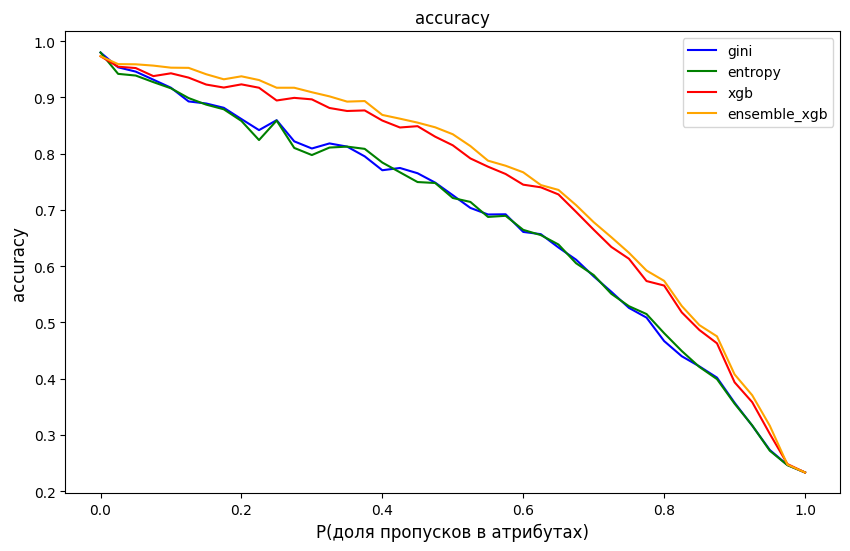

In [ ]:
probs=np.array([0 + 0.025 * i for i in range(0, 41)])
plt.figure(figsize=(10, 6))
plt.plot(probs, accuracy_gini, label="gini", color='blue')
plt.plot(probs, accuracy_entropy, label="entropy", color="green")
plt.plot(probs, accuracy_xgb, label="xgb", color="red")
plt.plot(probs, accuracy_ensemble_xgb, label="ensemble_xgb", color="orange")
plt.xlabel('P(доля пропусков в атрибутах)', fontsize=12)
plt.ylabel('accuracy', fontsize=12) 
plt.title("accuracy")
plt.legend(loc='best') 
plt.show()

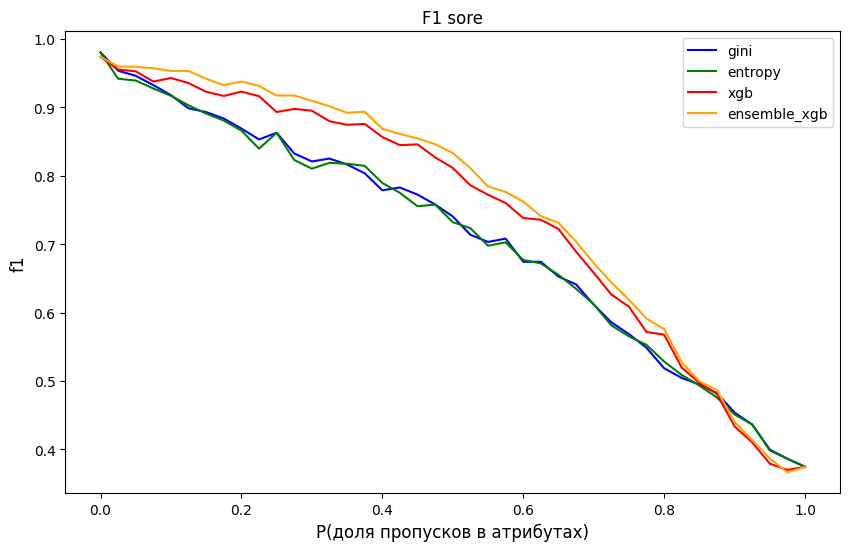

In [ ]:
probs=np.array([0 + 0.025 * i for i in range(0, 41)])
plt.figure(figsize=(10, 6))
plt.plot(probs, f1_gini, label="gini", color='blue')
plt.plot(probs, f1_entropy, label="entropy", color="green")
plt.plot(probs, f1_xgb, label="xgb", color="red")
plt.plot(probs, f1_ensemble_xgb, label="ensemble_xgb", color="orange")
plt.xlabel('P(доля пропусков в атрибутах)', fontsize=12)
plt.ylabel('f1', fontsize=12) 
plt.title("F1 sore")
plt.legend(loc='best') 
plt.show()

In [ ]:
mask = accuracy_gini >= 0.9
np.max(probs[mask])

0.1

In [ ]:
mask = accuracy_gini >= 0.85
np.max(probs[mask])

0.25

In [ ]:
mask = accuracy_gini >= 0.8
np.max(probs[mask])

0.35000000000000003

In [ ]:
mask = accuracy_gini >= 0.75
np.max(probs[mask])

0.45

### Вывод
Из графиков метрик, построенных на большом количестве разбиений и масок пропущенных атрибутов:

1. **Сравнение алгоритмов**:
   - Реализация дерева решений (Gini/Entropy) показывает **сопоставимую с XGBoost точность на данных без пропусков**:
     - `accuracy_gini = 0.98`, `accuracy_entropy = 0.98`, `accuracy_xgb = 0.9733`.
   - При увеличении доли пропусков (>0.1) XGBoost и 100 деревьев в ансамбле XGBoost демонстрируют **более высокую устойчивость**:
     - На доле пропусков 0.25: 
       - `accuracy_gini = 0.86`, `accuracy_xgb = 0.895`, `accuracy_ensemble_xgb = 0.917`.
     - На доле пропусков 0.4:
       - `accuracy_gini = 0.77`, `accuracy_xgb = 0.86`, `accuracy_ensemble_xgb = 0.87`.

2. **Пороговые значения**:
   - Дерево решений (Gini):
     - Точность >0.85 сохраняется при **доле пропусков ≤0.35**.
     - Точность >0.75 — при **доле пропусков ≤0.45**.
   - XGBoost:
     - Точность >0.85 сохраняется до **доли пропусков 0.5**.

4. **F1-score**:
   - Метрики F1 следуют аналогичной тенденции, но с **более резким падением** при увеличении пропусков.

5. **Ограничения**:
   - Результаты справедливы **только для MCAR-пропусков** (полностью случайные пропуски). 
   - При наличии зависимостей в пропусках (MAR/MNAR) производительность может снижаться сильнее.
   - Простота реализации дерева решений (без оптимизаций XGBoost) делает его пригодным для определенного типа задач.

**Итог**: Предложенная реализация дерева решений применима для задач с долей пропусков ≤0.4 и требованиями к простоте модели. Для данных с высокой долей пропусков предпочтительны методы XGBoost.